<center>
    <h1> Natural Language Processing</h1>
    <h2> Assignment 1 </h2>
    <a href="mailto:ildebrando.simeoni@studio.unibo.it">Ildebrando Simeoni</a>, <a href="mailto:diego.biagini2@studio.unibo.it">Diego Biagini</a>, <a href="mailto:matteo.donati10@studio.unibo.it">Matteo Donati</a>
</center>

<br>

Part-of-Speech (POS) tagging refers to the process of assigning a specific marker to each input token composing a given sentence. This process can also be seen as a disambiguation task. Indeed, the same token can be assigned a different marker, or tag, depending on the syntactical role the token plays in the given sentence.

This notebook performs POS tagging on a NLTK dataset<sup>[[1]](#references)</sup> using different neural architectures and GloVe embeddings<sup>[[2]](#references)</sup>.

## Libraries

All the useful libraries are imported below.

In [ ]:
import os
import urllib.request
import zipfile
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize

# Sets reproducibility.
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"
  os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

# Setting seed.
set_reproducibility(seed = 42)

## Data Analysis and Preprocessing

Both the dataset and GloVe embeddings are downloaded and extracted.

In [ ]:
# Downloads .zips.
def downloader(url, folder_name, filename):

  # Downloading .zip.
  data_path = os.path.join(os.getcwd(), folder_name)
  if not os.path.exists(data_path): 
    os.makedirs(data_path)
  zip_path = os.path.join(os.getcwd(), folder_name, filename)
  if not os.path.exists(zip_path): 
    urllib.request.urlretrieve(url, zip_path)

  # Extracting .zip.
  with zipfile.ZipFile(zip_path, "r") as zip_ref: 
    zip_ref.extractall(path = data_path)

  # Returning data_path and zip_path.
  return data_path, zip_path

# Downloading resources.
data_path, _ = downloader(url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip", folder_name = "data", filename = "dependency_treebank.zip")
glove_path, _ = downloader(url = "https://nlp.stanford.edu/data/glove.6B.zip", folder_name = "glove", filename = "glove.6B.zip")

The retrieved dataset contains 199 documents, each named `wsj_0xxx.dp`, where `xxx` goes from `001` to `199`. In particular, each document contains an arbitrary number of sentences, and it is structured based on three features: token, tag and some integer value which will not be considered.

To better understand the structure of each document, the content of `wsj_0001.dp` is printed below.

In [ ]:
# Printing content of the first document.
dataset_name = "dependency_treebank"
file_path = os.path.join(data_path, dataset_name, "wsj_0001.dp")
if os.path.isfile(file_path):
  with open(file_path, mode = "r") as text_file: print(text_file.read())

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



Embeddings are used to project each word onto a dense vector space. In particular, the dimensionaly of such space is defined by the constant `EMBEDDING_SIZE` that has been set equal to `50`. Thus, each token in the input sentences will be projected onto $\mathbb{R}^{50}$.

In the following cell, the GloVe `embedding_vocabulary` is used to print the embedding vector corresponding to the word `the`.

In [ ]:
# GloVe embedding size.
EMBEDDING_SIZE = 50

# Reading GloVe file.
glove_file = os.path.join(os.getcwd(), glove_path, f"glove.6B.{str(EMBEDDING_SIZE)}d.txt")
with open(glove_file, encoding = "utf8" ) as text_file: 
  lines = text_file.readlines()

# GloVe vocabulary.
embedding_vocabulary = {}

# Fill the vocabulary.
for line in lines:
  splits = line.split()
  embedding_vocabulary[splits[0]] = np.array([float(val) for val in splits[1:]])

# Printing embedding of "the".
print("The embedding for 'the' is:\n{}.".format(embedding_vocabulary["the"]))

The embedding for 'the' is:
[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01].


### Dataset Creation and Out-Of-Vocabulary (OOV) Terms

In order to easily build the list of embeddings for each sentence in the input documents, the function `get_embeddings` is defined. Such function takes as input the a list of words (`sentence`), the GloVe vocabulary (`vocabulary`) and the size of each embedding (`embedding_size`), and produces a list of vectors containing the embeddings for the tokens in the input sentence. However, not all the input terms have a corresponding embedding in GloVe. These terms are referred to as Out-Of-Vocabulary (OOV) terms. To maximize the probability of finding terms in GloVe, case-folding has been applied. In particular, all letters in each word of `sentence` are reduced to lower case.

The embedding vector for OOV terms is set equal to $\boldsymbol{0} ∈ \mathbb{R}^{50}$ (i.e. a vector composed of all zeros). During the development of this notebook, such embeddings have also been set equal to random vectors, but the final results were identical to the ones obtained considering $\boldsymbol{0} ∈ \mathbb{R}^{50}$. Thus, the remaining of this notebook will consider $\boldsymbol{0} ∈ \mathbb{R}^{50}$ as the default embedding for OOV terms.

The following cell also computes a dataframe that contains as many rows as the number of input sentences, and four columns:

*   `file_id`, that is the `xxx` id number of the `wsj_0xxx.dp` input file which stores the specific sentence. 
*   `sentence`, that is the list of words that compose a sentence.
*   `tags`, that is the list of tags related to each word of the corresponding sentence.
*   `features`, that is the list of GloVe embeddings related to each word of the corresponding sentence.

In [ ]:
# Retrieves embeddings for a sentence.
def get_embeddings(sentence, vocabulary, embedding_size):

  # List of embeddings for the input sentence.
  embeddings = []

  # Retrieving embedding vectors.
  for word in sentence:
    embedding = vocabulary.get(word.lower())
    if embedding is not None:
      embeddings.append(embedding)
    else:
      embeddings.append(list(np.zeros(embedding_size)))

  # Returning list of embeddings.
  return embeddings

dataframe_rows = []
row_words = []
row_tags = []
folder = os.path.join(data_path, dataset_name)

# Storing dataframe rows.
for filename in sorted(os.listdir(folder)):
  file_path = os.path.join(folder, filename)
  if os.path.isfile(file_path):

    # Reading content.
    with open(file_path, mode = "r") as text_file:
      while True:
        line = text_file.readline()

        # Storing a single word and a single tag.
        if line and line != "\n":
          row_words.append(line.split()[0])
          row_tags.append(line.split()[1])

        # Creating new dataframe row and resetting structures.
        else:
          dataframe_row = {"file_id": int(filename.split(".")[0].split("_")[1]), 
                           "sentence": row_words, 
                           "tags": row_tags, 
                           "features": get_embeddings(row_words, embedding_vocabulary, EMBEDDING_SIZE)}
          dataframe_rows.append(dataframe_row)
          row_words = []
          row_tags = []

          if not line: break

# Creating dataframe.
dataframe = pd.DataFrame(dataframe_rows)
dataframe.head()

,file_id,sentence,tags,features
0,1,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...","[[0.23568, 0.39638, -0.60135, -0.52681, 0.1587..."
1,1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...","[[0.006008, 0.57028, -0.064426, -0.044687, 0.8..."
2,2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...","[[0.86274, 0.056588, -0.081828, -0.35318, -0.0..."
3,3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...","[[0.21705, 0.46515, -0.46757, 0.10082, 1.0135,..."
4,3,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...","[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -..."


The computed dataframe is then splitted into training, validation and test portions according to the specifics of the problem. This is done by relying of the `file_id` column of the dataframe. In particular:

*   The training split considers documents from `wsj_0001.dp` to `wsj_0100.dp`.
*   The validation split considers documents from `wsj_0101.dp` to `wsj_0150.dp`.
*   The test split considers documents from `wsj_0151.dp` to `wsj_0199.dp`.

Being each document composed of an arbitrary number of sentences, each split contains a different number of rows (i.e. of sentences).

In [ ]:
# Defining splits.
TRAINING_SPLIT = range(1, 101)
VALIDATION_SPLIT = range(101, 151)
TEST_SPLIT = range(151, 200)

# Retrieving splits.
train = dataframe.loc[dataframe["file_id"].isin(TRAINING_SPLIT)]
validation = dataframe.loc[dataframe["file_id"].isin(VALIDATION_SPLIT)]
test = dataframe.loc[dataframe["file_id"].isin(TEST_SPLIT)]

# Printing number of sentences.
print(f"The dataframe consists of {len(dataframe)} sentences:")
print(f" - {len(train)} of these sentences define the training set.")
print(f" - {len(validation)} of these sentences define the validation set.")
print(f" - {len(test)} of these sentences define the test set.")

The dataframe consists of 3914 sentences:
 - 1963 of these sentences define the training set.
 - 1299 of these sentences define the validation set.
 - 652 of these sentences define the test set.


In order to have, for each sentence, a matrix of embeddings of the same shape, the maximum length (`MAX_LENGTH`) of a sentence is computed by only looking at the training set. Once computed, such length is used to pad all the list of features. Thus:

*   The shape of `train_features` is: `len(train)` $\times$ `MAX_LENGTH` $\times$ `EMBEDDING_SIZE`.
*   The shape of `validation_features` is: `len(validation)` $\times$ `MAX_LENGTH` $\times$ `EMBEDDING_SIZE`.
*   The shape of `test_features` is: `len(test)` $\times$ `MAX_LENGTH` $\times$ `EMBEDDING_SIZE`.

where `train`, `validation`, `test` are the splits of the original dataframe computed above. Moreover, the padding operation is computed by using $\boldsymbol{0} \in \mathbb{R}^{50}$ as pad value.

In [ ]:
# Computing length of longest train sentence.
MAX_LENGTH = len(max(train["sentence"].tolist(), key = len))

# Padding features.
train_features = pad_sequences(train["features"].tolist(), maxlen = MAX_LENGTH, padding = "post", dtype = "float32")
validation_features = pad_sequences(validation["features"].tolist(), maxlen = MAX_LENGTH, padding = "post", dtype = "float32")
test_features = pad_sequences(test["features"].tolist(), maxlen = MAX_LENGTH, padding = "post", dtype = "float32")

# Printing shape of features.
print(f"The maximum length is {MAX_LENGTH}, thus:")
print(f" - The shape of train_features is: ({len(train_features)}, {len(train_features[0])}, {len(train_features[0, 0])}).")
print(f" - The shape of validation_features is: ({len(validation_features)}, {len(validation_features[0])}, {len(validation_features[0, 0])}).")
print(f" - The shape of test_features is: ({len(test_features)}, {len(test_features[0])}, {len(test_features[0, 0])}).")

The maximum length is 249, thus:
 - The shape of train_features is: (1963, 249, 50).
 - The shape of validation_features is: (1299, 249, 50).
 - The shape of test_features is: (652, 249, 50).


The train, validation and test tags are computed considering the `train`, `validation` and `test` splits respectively. Starting from such sets, the list of unique tags (`tags`) is then printed.

In [ ]:
# Computing tags.
train_tags = [item for sublist in train["tags"].tolist() for item in sublist]
validation_tags = [item for sublist in validation["tags"].tolist() for item in sublist]
test_tags = [item for sublist in test["tags"].tolist() for item in sublist]

# Removing duplicates from train_tags. The training set already contains all of the tags. 
# By using a dict instead of a set I can get reproducible results (sets are not ordered).
tags = list(dict.fromkeys(train_tags))

# Printing all the tags.
print(f"The possible tags are: {tags}.")

The possible tags are: ['NNP', ',', 'CD', 'NNS', 'JJ', 'MD', 'VB', 'DT', 'NN', 'IN', '.', 'VBZ', 'VBG', 'CC', 'VBD', 'VBN', 'RB', 'TO', 'PRP', 'RBR', 'WDT', 'VBP', 'RP', 'PRP$', 'JJS', 'POS', '``', 'EX', "''", 'WP', ':', 'JJR', 'WRB', '$', 'NNPS', 'WP$', '-LRB-', '-RRB-', 'PDT', 'RBS', 'FW', 'UH', 'SYM', 'LS', '#'].


According to the specifics of the problem, punctuation/symbols classes should not be considered when computing the final scores, but they should also not be removed from the dataframe due to their importance in understanding the syntactical structure of a sentence. Thus, the tags

`"PAD"` plus `[",", ".", "``", "''", ":", "$", "-LRB-", "-RRB-", "SYM", "LS", "#"]`

are stored in a specific list that will be useful to compute the final results. 

In [ ]:
# Punctuation tag list.
punctuation_tag_list = ["PAD", ",", ".", "``", "''", ":", "$", "-LRB-", "-RRB-", "SYM", "LS", "#"]

# Figures folder.
figures_path = os.path.join(os.getcwd(), "figures")
if not os.path.exists(figures_path): 
  os.makedirs(figures_path)

# Plots classes distribution.
def plot_classes_distribution(classes, counts, filename, figures_path = figures_path):

  # Plot.
  fig, ax = plt.subplots(1, 1, figsize = (9, 4))
  bars = ax.bar(np.arange(0, len(classes), 1), counts)

  # Setting opacity to punctuation bars.
  for i in range(len(classes)): 
    if classes[i] in punctuation_tag_list: bars[i].set_alpha(0.5)

  # Setting plot attributes.
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.set_yscale("log")
  ax.set_xticks(np.arange(0, len(classes), 1))
  ax.set_xticklabels(classes, rotation = 90)

  fig.savefig(f"{figures_path}/{filename}_classes_distribution.pdf", bbox_inches = "tight")
  plt.show()

The following cells compute and plot the distribution of classes in all three splits. Moreover, when considering the validation and test splits, there are classes that do not have support (namely, there are classes that do not appear at all in such splits). In such cases, these missing classes are shown below the corresponding barplot.

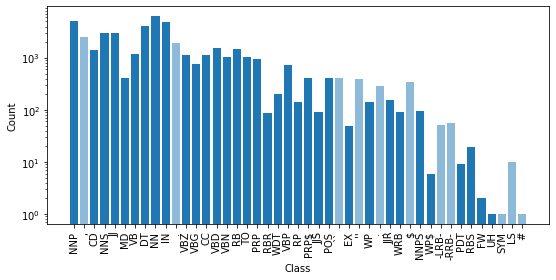

In [ ]:
# Train distribution
training_counts = [train_tags.count(tag) for tag in tags]
plot_classes_distribution(tags, training_counts, "training")

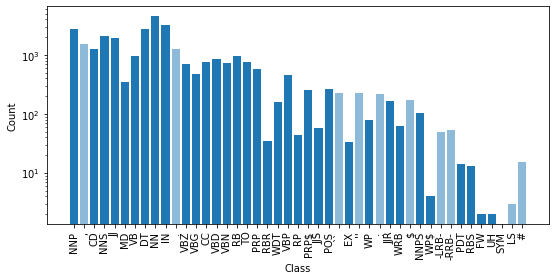

In [ ]:
# Validation distribution
validation_counts = [validation_tags.count(tag) for tag in tags]
plot_classes_distribution(tags, validation_counts, "validation")

In [ ]:
print(f"The classes {[tags[tag_index] for tag_index in np.argwhere(np.array(validation_counts) == 0).flatten()]} have zero support in the validation set.")

The classes ['SYM'] have zero support in the validation set.


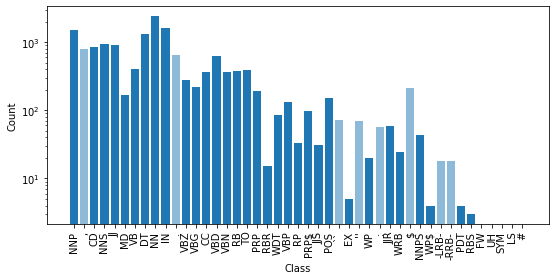

In [ ]:
# Test distribution.
test_counts = [test_tags.count(tag) for tag in tags]
plot_classes_distribution(tags, test_counts, "test")

In [ ]:
print(f"The classes {[tags[tag_index] for tag_index in np.argwhere(np.array(test_counts) == 0).flatten()]} have zero support in the test set.")

The classes ['FW', 'UH', 'SYM', 'LS', '#'] have zero support in the test set.


The last step of data preprocessing involves converting each categorical tag into a numerical value. This has been done by defining a vocabulary of tags (`tag_to_index`) that maps each categorical class into a unique numerical value. For example, the tag `PAD` is mapped into `0`, the tag `NNP` is mapped into `1`, etc.

By using the aforementioned vocabulary, it is possible to map `train_tags`, `validation_tags` and `test_tags` into their corresponding numerical variant. Moreover, the same sort of padding that was applied to the embeddings, now is applied to such list of tags. Thus:

*   The shape of `train_tags` is: `len(train)` $\times$ `MAX_LENGTH`.
*   The shape of `validation_tags` is: `len(validation)` $\times$ `MAX_LENGTH`.
*   The shape of `test_tags` is: `len(test)` $\times$ `MAX_LENGTH`.

In [ ]:
# Vocabulary for tags.
tag_to_index = {}
tag_to_index["PAD"] = 0
for i, tag in enumerate(list(tags)): 
  tag_to_index[tag] = i + 1

# Tag-to-index transformation using tag_to_index.
train_tags = [[tag_to_index[tag] for tag in tags_list] for tags_list in list(train["tags"])]
validation_tags = [[tag_to_index[tag] for tag in tags_list] for tags_list in list(validation["tags"])]
test_tags = [[tag_to_index[tag] for tag in tags_list] for tags_list in list(test["tags"])]

# Padding tags.
train_tags = pad_sequences(train_tags, maxlen = MAX_LENGTH, padding = "post")
validation_tags = pad_sequences(validation_tags, maxlen = MAX_LENGTH, padding = "post")
test_tags = pad_sequences(test_tags, maxlen = MAX_LENGTH, padding = "post")

# Printing shapes.
print(f"The shape of train_tags is: ({len(train_tags)}, {len(train_tags[0])}).")
print(f"The shape of validation_tags is: ({len(validation_tags)}, {len(validation_tags[0])}).")
print(f"The shape of test_tags is: ({len(test_tags)}, {len(test_tags[0])}).")

The shape of train_tags is: (1963, 249).
The shape of validation_tags is: (1299, 249).
The shape of test_tags is: (652, 249).


## Models Definition and Training

According to the specific of the assignment, four architectures are considered:

*   Baseline model, $m_0$, composed of:
  - a BiLSTM layer;
  - a time-distributed, dense layer with softmax activation.

*   BiGRU model, $m_1$, composed of:
  - a BiGRU layer;
  - a time-distributed, dense layer with softmax activation.

*   Additional BiLSTM model, $m_2$, composed of:
  - two BiLSTM layers;
  - a time-distributed, dense layer with softmax activation.

*   Additional dense layer model, $m_3$, composed of:
  - a BiLSTM layer.
  - a time-distributed, dense layer with ReLU activation.
  - a time-distributed, dense layer with softmax activation.

The optimal number of units/neurons for LSTM/GRU/dense layers is found using a grid-search approach (via the `grid_search` function). More details on this approach can be found below.

The hyper-paramenters of the learning procedure (i.e. batch-size, number of epochs, learning rate) are fixed. Moreover, in order to find the best possible models, both early-stopping (via `EarlyStopping`) and a learning rate schedule (via `ReduceLROnPlateau`) have been defined.

In [ ]:
# Models names and description.
models_name = ["m_0", "m_1", "m_2", "m_3"]
descriptions_dict = {models_name[0]: (f"Baseline model ({models_name[0]}): \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function."),
                     models_name[1]: (f"BiGRU model ({models_name[1]}): \n"
                                      " - Bi-directional GRU layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function."),
                     models_name[2]: (f"Additional bi-directional LSTM model ({models_name[2]}): \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function."),
                     models_name[3]: (f"Additional dense layer model ({models_name[3]}): \n"
                                      " - Bi-directional LSTM layer. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - ReLU activation function. \n"
                                      " - Time-distributed dense layer. \n"
                                      " - Softmax activation function.")}

# Dictionary of models.
models = {}

# Training procedure hyper-parameters and callbacks.
BATCH_SIZE = 128
EPOCHS = 100
LR = 0.01
REG = 0.01
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", patience = 3, factor = 0.1)

# Creates the model.
def get_model(name, layers, input_shape):

  # Model.
  model = Sequential()
  model.add(InputLayer(input_shape = input_shape))
  for layer in layers:
    model.add(layer)
  model.add(TimeDistributed(Dense(len(tag_to_index), activation = "softmax")))
  model._name = name

  # Returning the model.
  return model

# Applies grid-search to tune a specific architecture.
def grid_search(model_name, units, best_baseline_LSTM_units = None):

  # Models and histories of the same architecture.
  models = []
  histories = []

  print(f"Grid-search, {model_name} model.")

  # Grid-search over possible number of units so to find the best model.
  for n in units:
    if model_name == "m_0":
      layers = [Bidirectional(LSTM(n, return_sequences = True, recurrent_regularizer = l2(REG)))]
    elif model_name == "m_1":
      layers = [Bidirectional(GRU(n, return_sequences = True, recurrent_regularizer = l2(REG)))]
    elif model_name == "m_2" and best_baseline_LSTM_units != None:
      layers = [Bidirectional(LSTM(best_baseline_LSTM_units, return_sequences = True, recurrent_regularizer = l2(REG))),
                Bidirectional(LSTM(n, return_sequences = True, recurrent_regularizer = l2(REG)))]
    elif model_name == "m_3" and best_baseline_LSTM_units != None:
      layers = [Bidirectional(LSTM(best_baseline_LSTM_units, return_sequences = True, recurrent_regularizer = l2(REG))),
                TimeDistributed(Dense(n, activation = "relu"))]

    # Creating the model.
    model = get_model(name = model_name, layers = layers, input_shape = (MAX_LENGTH, EMBEDDING_SIZE))
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(LR), metrics = ["accuracy"])
    models.append(model)
    print(f"\nNumber of units: {n}.\n")
    models[-1].summary()

    # Fitting the model.
    history = models[-1].fit(train_features, train_tags, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (validation_features, validation_tags), callbacks = [early_stopping, reduce_lr])
    histories.append(history)

  # Returning models and histories.
  return models, histories

The functions `compute_F1_score` and `get_best_model` compute, respectively, the macro F1-score without considering punctuation/symbols/zero-support classes, and the best model, according to such score, among all the variations of the same architecture after having performed grid-search.

In [ ]:
# Compute the macro F1-score.
def compute_F1_score(model, X, y, tag_to_index_vocabulary):

  pred = model.predict(X)
  report = classification_report(y.flatten(), 
                                 np.argmax(pred, axis = 2).flatten(), 
                                 labels = np.arange(0, len(tag_to_index_vocabulary), 1),
                                 target_names = list(tag_to_index_vocabulary.keys()),
                                 zero_division = 0,
                                 output_dict = True)

  # Computing macro F1-score.
  macro_f1 = 0
  for tag in list(tag_to_index_vocabulary.keys()):
    if tag not in punctuation_tag_list: 
      macro_f1 = macro_f1 + report[tag]["f1-score"]
  macro_f1 = macro_f1 / (len(list(tag_to_index_vocabulary.keys())) - len(punctuation_tag_list))

  # Returning macro F1-score, predictions and report.
  return macro_f1, pred, report

# Retrieves the best model among a set of models.
def get_best_model(models, units):

  # Computing best F1-score.
  f1_scores = [compute_F1_score(model, validation_features, validation_tags, tag_to_index)[0] for model in models]
  best = units[np.argmax(f1_scores)]
  print(f"The best number of units is: {best}.")

  # Returning the best model, all the F1-scores.
  return best, f1_scores, models[np.argmax(f1_scores)]

The following cell defines two other functions, `plot_loss` and `plot_f1_scores` that are used, respectively, to plot the training loss curves and macro F1-scores, of each architecture, after having performed grid-search.

In [ ]:
# Plots validation losses.
def plot_loss(model_name, units, histories, figures_path = figures_path):

  # Computing best epoch for each model.
  best_epochs = [np.argmin(history.history["val_loss"]) + 1 for history in histories]

  # Plotting val loss for each model.
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))
  for i in range(len(units)):
    x = np.arange(1, len(histories[i].history["val_loss"]) + 1, 1)
    ax.plot(x, histories[i].history["val_loss"], label = r"${}^{}$".format(model_name, i + 1))

  # Setting attributes.
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epoch")
  ax.legend()

  fig.savefig(f"{figures_path}/val_loss_{model_name}.pdf", bbox_inches = "tight")
  plt.show

# Plots F1-scores.
def plot_f1_scores(model_name, units, f1_scores, figures_path = figures_path):
  
  # Plotting F1-scores.
  fig, ax = plt.subplots(1, 1, figsize = (4, 4))
  ax.plot(np.arange(0, len(f1_scores), 1), f1_scores, marker = "o")

  # Setting attributes.
  ax.set_ylabel(r"$F_1$-score")
  ax.set_xlabel("Model")
  ax.set_xticks(np.arange(0, len(f1_scores), 1))
  ax.set_xticklabels([r"${}^{}$".format(model_name, i + 1) for i in range(len(units))])

  fig.savefig(f"{figures_path}/f1_scores_{model_name}.pdf", bbox_inches = "tight")
  plt.show

### Baseline Model ($m_0$)

Grid-search on $m_0$ is performed by searching for the best number of LSTM units. The possible number of units are $\{32, 64, 128, 256\}$, which define four models: $m_0^1$, $m_0^2$, $m_0^3$, $m_0^4$ respectively.

In [ ]:
# Grid-search over possible units.
baseline_units = [32, 64, 128, 256]
baseline_models, baseline_model_histories = grid_search(models_name[0], baseline_units)

Grid-search, m_0 model.

Number of units: 32.

Model: "m_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 249, 64)          21248     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 249, 46)          2990      
 ibuted)                                                         
                                                                 
Total params: 24,238
Trainable params: 24,238
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 10s 114ms/step - loss: 1.8719 - accuracy: 0.8906 - val_loss: 0.5530 - val_accuracy: 0.9305 - lr: 0.0100
Epoch 2/100
16/16 [==============================] - 1s 40ms/step - loss: 0.4803 - accuracy: 0.9394 - val_loss: 0.3939 

After having fitted each of the four models, the best one is chosen by executing the `get_best_model` function.

In [ ]:
baseline_best_units, baseline_f1_scores, models[models_name[0]] = get_best_model(baseline_models, baseline_units)

41/41 [==============================] - 1s 14ms/step
The best number of units is: 256.


Lastly, both the validation loss curves and the macro F1-scores are plotted using the `plot_loss` and `plot_f1_scores` functions.

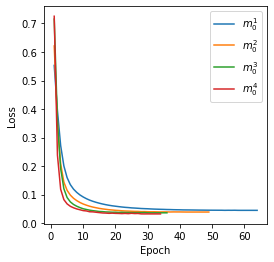

In [ ]:
plot_loss(models_name[0], baseline_units, baseline_model_histories)

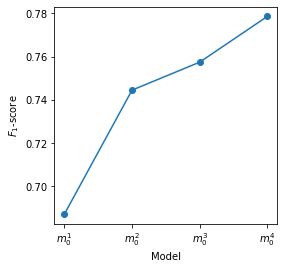

In [ ]:
plot_f1_scores(models_name[0], baseline_units, baseline_f1_scores)

### BiGRU Model ($m_1$)

Grid-search on $m_1$ is performed by searching for the best number of GRU units. The possible number of units are $\{32, 64, 128, 256\}$, which define four models: $m_1^1$, $m_1^2$, $m_1^3$, $m_1^4$ respectively.

In [ ]:
# Grid-search over possible units.
gru_units = [32, 64, 128, 256]
gru_models, gru_model_histories = grid_search(models_name[1], gru_units)

Grid-search, m_1 model.

Number of units: 32.

Model: "m_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 249, 64)          16128     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 249, 46)          2990      
 tributed)                                                       
                                                                 
Total params: 19,118
Trainable params: 19,118
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 5s 102ms/step - loss: 1.9700 - accuracy: 0.9153 - val_loss: 0.5253 - val_accuracy: 0.9415 - lr: 0.0100
Epoch 2/100
16/16 [==============================] - 1s 40ms/step - loss: 0.4526 - accuracy: 0.9465 - val_loss: 0.3506 -

After having fitted each of the four models, the best one is chosen by executing the `get_best_model` function.

In [ ]:
_, gru_f1_scores, models[models_name[1]] = get_best_model(gru_models, gru_units)

41/41 [==============================] - 1s 14ms/step
The best number of units is: 256.


Lastly, both the validation loss curves and the macro F1-scores are plotted using the `plot_loss` and `plot_f1_scores` functions.

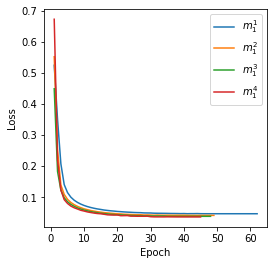

In [ ]:
plot_loss(models_name[1], gru_units, gru_model_histories)

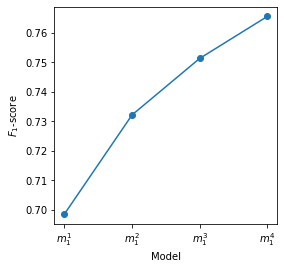

In [ ]:
plot_f1_scores(models_name[1], gru_units, gru_f1_scores)

### Additional BiLSTM Model ($m_2$)

Grid-search on $m_2$ is performed by searching for the best number of LSTM units within the second BiLSTM layer. The possible number of units are $\{32, 64, 128, 256\}$, which define four models: $m_2^1$, $m_2^2$, $m_2^3$, $m_2^4$ respectively.

In [ ]:
# Grid-search over possible units.
double_lstm_units = [32, 64, 128, 256]
double_lstm_models, double_lstm_model_histories = grid_search(models_name[2], double_lstm_units, baseline_best_units)

Grid-search, m_2 model.

Number of units: 32.

Model: "m_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 249, 512)         628736    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 249, 64)          139520    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 249, 46)          2990      
 tributed)                                                       
                                                                 
Total params: 771,246
Trainable params: 771,246
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 9s 227ms/step - loss: 2

After having fitted each of the four models, the best one is chosen by executing the `get_best_model` function.

In [ ]:
_, double_lstm_f1_scores, models[models_name[2]] = get_best_model(double_lstm_models, double_lstm_units)

41/41 [==============================] - 2s 27ms/step
The best number of units is: 256.


Lastly, both the validation loss curves and the macro F1-scores are plotted using the `plot_loss` and `plot_f1_scores` functions.

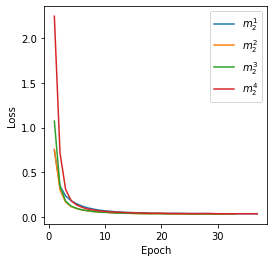

In [ ]:
plot_loss(models_name[2], double_lstm_units, double_lstm_model_histories)

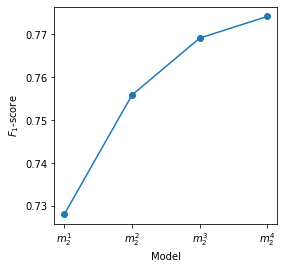

In [ ]:
plot_f1_scores(models_name[2], double_lstm_units, double_lstm_f1_scores)

### Additional Dense Layer Model ($m_3$)

Grid-search on $m_3$ is performed by searching for the best number of neurons within the first dense layer. The possible number of neurons are $\{32, 64, 128, 256\}$, which define four models: $m_3^1$, $m_3^2$, $m_3^3$, $m_3^4$ respectively.

In [ ]:
# Grid-search over possible units.
double_dense_units = [32, 64, 128, 256]
double_dense_models, double_dense_model_histories = grid_search(models_name[3], double_dense_units, baseline_best_units)

Grid-search, m_3 model.

Number of units: 32.

Model: "m_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 249, 512)         628736    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 249, 32)          16416     
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 249, 46)          1518      
 stributed)                                                      
                                                                 
Total params: 646,670
Trainable params: 646,670
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 5s 156ms/step - loss: 2

After having fitted each of the four models, the best one is chosen by executing the `get_best_model` function.

In [ ]:
_, double_dense_f1_scores, models[models_name[3]] = get_best_model(double_dense_models, double_dense_units)

41/41 [==============================] - 1s 13ms/step
The best number of units is: 128.


Lastly, both the validation loss curves and the macro F1-scores are plotted using the `plot_loss` and `plot_f1_scores` functions.

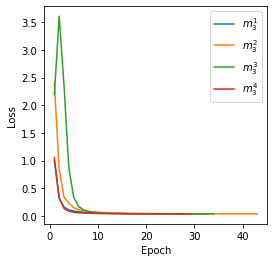

In [ ]:
plot_loss(models_name[3], double_dense_units, double_dense_model_histories)

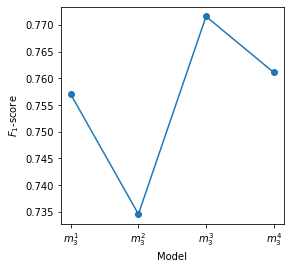

In [ ]:
plot_f1_scores(models_name[3], double_dense_units, double_dense_f1_scores)

## Models Testing

The best models, according to the training results, are $m_0^4$, $m_1^4$, $m_2^4$ and $m_3^3$. For each of these models, the macro F1-score on the validation split is printed below. Only the two best models must be tested using the test set.

In [ ]:
# Best validation models.
models_val_score = {}
best_val_pred = {}
models_val_report = {}

# Computing macro F1-scores on the four models selected with grid-search.
for model in models:
  print(f"{descriptions_dict[model]}\n")
  models_val_score[model], best_val_pred[model], models_val_report[model] = compute_F1_score(models[model], validation_features, validation_tags, tag_to_index)
  print(f"The macro F1-score for model {model} is: {models_val_score[model]}.\n")

# Storing the two best models.
best_models = sorted(models_val_score, key = models_val_score.get, reverse = True)[:2]

Baseline model (m_0): 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 13ms/step
The macro F1-score for model m_0 is: 0.7785212201881775.

BiGRU model (m_1): 
 - Bi-directional GRU layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 13ms/step
The macro F1-score for model m_1 is: 0.7654758586112104.

Additional bi-directional LSTM model (m_2): 
 - Bi-directional LSTM layer. 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 25ms/step
The macro F1-score for model m_2 is: 0.774168597116443.

Additional dense layer model (m_3): 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - ReLU activation function. 
 - Time-distributed dense layer. 
 - Softmax activation function.

41/41 [==============================] - 1s 14ms/step


Thus, the two models that will be tested on the test split are $m_0^4$ and $m_2^4$.

In [ ]:
# Best test models.
models_test_score = {}
best_test_pred = {}
models_test_report = {}

# Testing the two best models.
for model in best_models:
  print(f"{descriptions_dict[model]}\n")
  models_test_score[model], best_test_pred[model], models_test_report[model] = compute_F1_score(models[model], test_features, test_tags, tag_to_index)
  print(f"The macro F1-score, on the test set, for model {model} is: {models_test_score[model]}.\n")

Baseline model (m_0): 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

21/21 [==============================] - 0s 13ms/step
The macro F1-score, on the test set, for model m_0 is: 0.7828587014572577.

Additional bi-directional LSTM model (m_2): 
 - Bi-directional LSTM layer. 
 - Bi-directional LSTM layer. 
 - Time-distributed dense layer. 
 - Softmax activation function.

21/21 [==============================] - 1s 26ms/step
The macro F1-score, on the test set, for model m_2 is: 0.7556192872287104.



One can notice how, in the case of both $m_0^4$ and $m_2^4$, the macro F1-score computed on the test split in similar to the one computed on the validation split.

## Error Analysis

Given the two best models, $m_0^4$ and $m_2^4$, some error analysis is permorfed. In particular, this section highlights the following:

*   The error rate computed on both the validation and test splits.
*   The macro precision and recall computed on both the validation and test splits.
*   The confusion matrices, for both models, computed on the test set.
*   Some of the most miss-classified test samples for both models.

The following cell defines the `get_masked_labels` function, that is used to compute a masked version of the vectors containing the true and predicted labels produced by a given model. The result of such function can be used to compute the error rate on a specific data split or on a single sentence.

In [ ]:
# Removes punctuation/symbols tags from true and predicted labels.
def get_masked_labels(true_labels, pred_labels, tag_to_index, punctuation_tag_list):

  # Tag-to-index transformation.
  punctuation_indexes = [tag_to_index[tag] for tag in punctuation_tag_list]

  # Removing punctuatin/symbols.
  mask = np.isin(true_labels, punctuation_indexes)
  true = np.delete(true_labels, mask)
  pred = np.delete(pred_labels, mask)

  # Returning true, pred and punctuation_indexes.
  return true, pred, punctuation_indexes

# Plotting error rates for best models.
for model in best_models:

  # Validation error rate.
  model_val_pred = np.argmax(best_val_pred[model], axis = 2).flatten()
  true, pred, _ = get_masked_labels(validation_tags.flatten(), model_val_pred, tag_to_index, punctuation_tag_list)
  print("The error rate, on the validation set, for model {} is: {}%.".format(model, np.sum(true != pred) * 100 / len(true)))

  # Test error rate.
  model_test_pred = np.argmax(best_test_pred[model], axis = 2).flatten()
  true, pred, _ = get_masked_labels(test_tags.flatten(), model_test_pred, tag_to_index, punctuation_tag_list)
  print("The error rate, on the test set, for model {} is: {}%.".format(model, np.sum(true != pred) * 100 / len(true)))

The error rate, on the validation set, for model m_0 is: 10.472369140981215%.
The error rate, on the test set, for model m_0 is: 9.578824217607487%.
The error rate, on the validation set, for model m_2 is: 10.603684114535838%.
The error rate, on the test set, for model m_2 is: 10.105293945598127%.


From the computed values, one can notice how the error rates on the test set are lower than the error rates computed on the validation set. This is mainly due to the fact that the test set have more zero-support classes than the validation set. As mentioned above, the only class that has zero support in the validation split is `['SYM']`, while the classes that have zero support in the test set are `['FW', 'UH', 'SYM', 'LS', '#']`. In particular, `SYM`, `LS` and `#` are punctuation/symbols tags, so they are not considered when computing the final results. However, when looking at the training set distribution, one can notice how `FW` and `UH` have low support, and so the models are not able to effectively learn how to correctly classify tokens of these classes. The fact that the classes `FW` and `UH` are only present in the validation split, and not in the test split, makes the error rate for the test set lower than the error rate for the validation set.

To prove this, the following cell prints the F1-scores associated with such tags, showing that, indeed, the models are not able to correctly classify samples related to such classes.

In [ ]:
# Printing F1-score for classes FW and UH, which have little support in training set, and no support in test set.
for model in best_models:
  print("The F1-score, on the validation set, for class FW and model {} is: {}".format(model, models_val_report[model]["FW"]["f1-score"]))
  print("The F1-score, on the validation set, for class UH and model {} is: {}".format(model, models_val_report[model]["UH"]["f1-score"]))

The F1-score, on the validation set, for class FW and model m_0 is: 0.0
The F1-score, on the validation set, for class UH and model m_0 is: 0.0
The F1-score, on the validation set, for class FW and model m_2 is: 0.0
The F1-score, on the validation set, for class UH and model m_2 is: 0.0


Indeed, from the results printed above, one can notice how the macro F1-scores are equal to zero.

Next, the two most frequent classes (`NN` and `IN`) and the two least frequent classes (`WP$` and `RBS`) are analysed below. In particular, for such classes, the macro F1-score on both the validation and test splits is computed and finally printed.

In [ ]:
# Printing F1-score for classes NN, IN, WP$ and RBS.
for model in best_models:
  print("The F1-score, on the validation set, for class NN and model {} is: {}".format(model, models_val_report[model]["NN"]["f1-score"]))
  print("The F1-score, on the test set, for class NN and model {} is: {}".format(model, models_test_report[model]["NN"]["f1-score"]))
  print("The F1-score, on the validation set, for class IN and model {} is: {}".format(model, models_val_report[model]["IN"]["f1-score"]))
  print("The F1-score, on the test set, for class IN and model {} is: {}".format(model, models_test_report[model]["IN"]["f1-score"]))
  print("The F1-score, on the validation set, for class WP$ and model {} is: {}".format(model, models_val_report[model]["WP$"]["f1-score"]))
  print("The F1-score, on the test set, for class WP$ and model {} is: {}".format(model, models_test_report[model]["WP$"]["f1-score"]))
  print("The F1-score, on the validation set, for class RBS and model {} is: {}".format(model, models_val_report[model]["RBS"]["f1-score"]))
  print("The F1-score, on the test set, for class RBS and model {} is: {}".format(model, models_test_report[model]["RBS"]["f1-score"]))

The F1-score, on the validation set, for class NN and model m_0 is: 0.8597646550793479
The F1-score, on the test set, for class NN and model m_0 is: 0.8752086811352253
The F1-score, on the validation set, for class IN and model m_0 is: 0.9674247080516288
The F1-score, on the test set, for class IN and model m_0 is: 0.9692642036634586
The F1-score, on the validation set, for class WP$ and model m_0 is: 0.8571428571428571
The F1-score, on the test set, for class WP$ and model m_0 is: 1.0
The F1-score, on the validation set, for class RBS and model m_0 is: 0.6896551724137931
The F1-score, on the test set, for class RBS and model m_0 is: 0.5714285714285715
The F1-score, on the validation set, for class NN and model m_2 is: 0.8577373781623043
The F1-score, on the test set, for class NN and model m_2 is: 0.8750264326496088
The F1-score, on the validation set, for class IN and model m_2 is: 0.9722136461870947
The F1-score, on the test set, for class IN and model m_2 is: 0.9693023255813953
The

Thus, the two most frequent classes, alongside one of the two least frequent classes (`WP$`) show a high macro F1-score. On the other hand, the score for class `RBS` results to be a relatively low score.

Then, the macro precision and macro recall values are computed for both the validation and test plits.

In [ ]:
# Computing macro precision and macro recall for best models.
for model in best_models:

  val_precision = 0
  test_precision = 0
  val_recall = 0
  test_recall = 0

  for tag in list(tag_to_index.keys()):

    # Escluding punctuation/symbols.
    if tag not in punctuation_tag_list:
      val_precision = val_precision + models_val_report[model][tag]["precision"]
      test_precision = test_precision + models_test_report[model][tag]["precision"]
      val_recall = val_recall + models_val_report[model][tag]["recall"]
      test_recall = test_recall + models_test_report[model][tag]["recall"]

  val_precision = val_precision / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))
  test_precision = test_precision / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))
  val_recall = val_recall / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))
  test_recall = test_recall / (len(list(tag_to_index.keys())) - len(punctuation_tag_list))

  print(f"The macro precision, on the validation set, for model {model} is: {val_precision}.")
  print(f"The macro precision, on the test set, for model {model} is: {test_precision}.")
  print(f"The macro recall, on the validation set, for model {model} is: {val_recall}.")
  print(f"The macro recall, on the test set, for model {model} is: {test_recall}.")

The macro precision, on the validation set, for model m_0 is: 0.7949423599795876.
The macro precision, on the test set, for model m_0 is: 0.7859061522269339.
The macro recall, on the validation set, for model m_0 is: 0.7777471631723517.
The macro recall, on the test set, for model m_0 is: 0.7872453784448298.
The macro precision, on the validation set, for model m_2 is: 0.7795868588428165.
The macro precision, on the test set, for model m_2 is: 0.7601004062955243.
The macro recall, on the validation set, for model m_2 is: 0.777734976345458.
The macro recall, on the test set, for model m_2 is: 0.7575691496206607.


Just like in the case of macro F1-scores, also macro precision and macro recall on validation and test splits are similar.

The next cell defines the `get_confusion_matrix` function that is able to compute the confusion matrix for a specific data split. In particular, this function is defined in such a way to not consider punctuation, symbols, and zero-support classes. This is done by inserting a specific row/column, called `OTHERS`, which includes all punctuation, symbols and zero-support tags. Lastly, the computed matrices are normalized in a row-wise manner, highlighting recall information about each class.

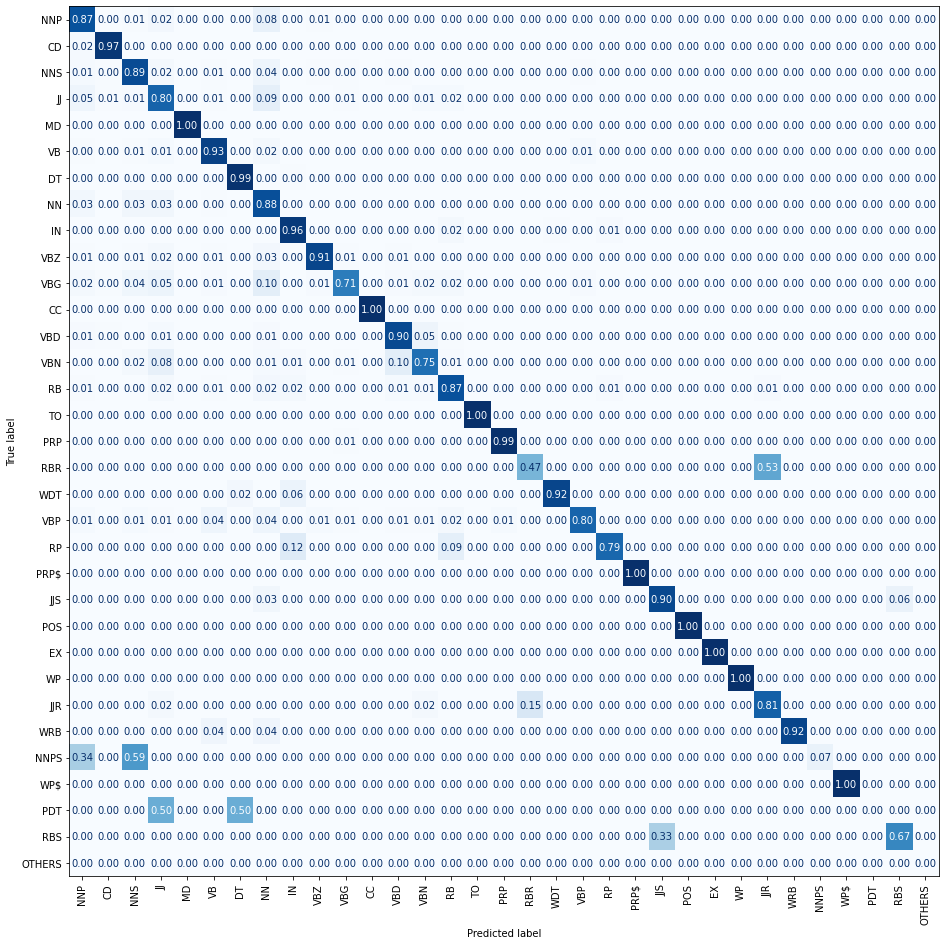

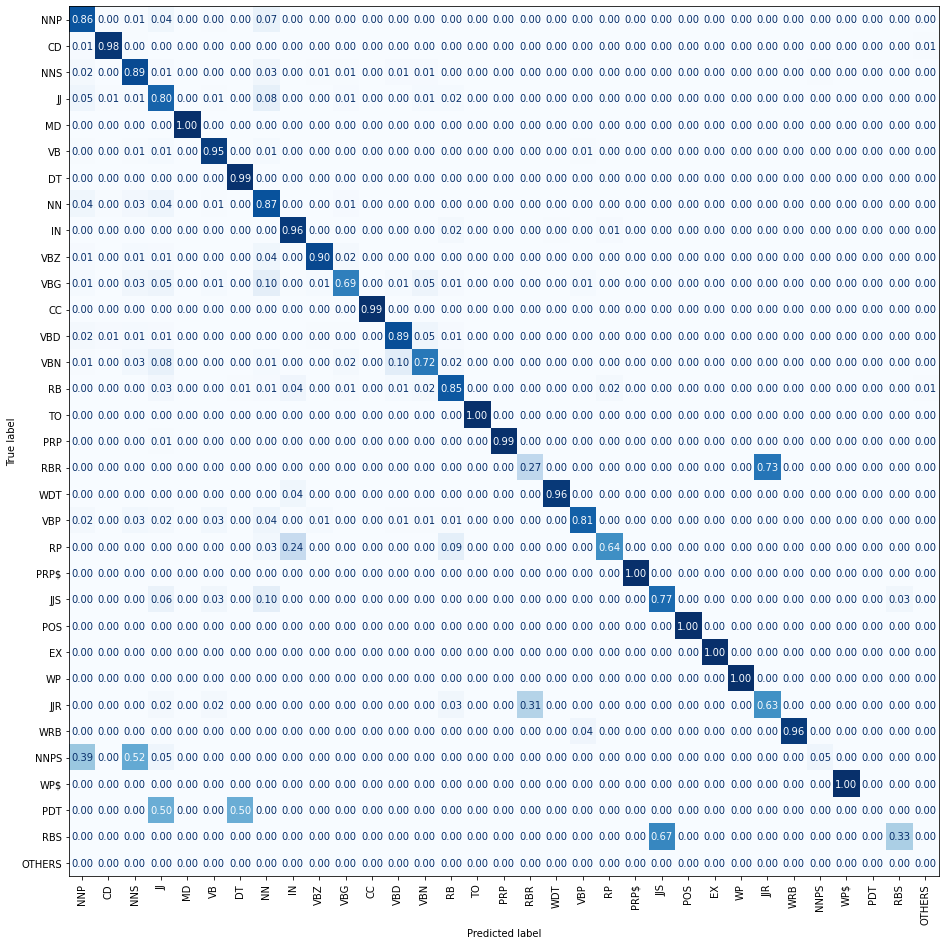

In [ ]:
# Computes confusion matrix escluding punctuation/symbols.
def get_confusion_matrix(true_labels, pred_labels, punctuation_tag_list, zero_support_indexes, tag_to_index, norm = None):

  # Computing list of unique classes.
  true, pred, punctuation_indexes = get_masked_labels(true_labels, pred_labels, tag_to_index, punctuation_tag_list)
  true_classes = np.unique(true)

  # List containing indexes of punctuation tags or zero-support tags.
  to_be_removed = []
  to_be_removed.extend(punctuation_indexes)
  to_be_removed.extend(zero_support_indexes)
  to_be_removed = list(dict.fromkeys(to_be_removed))

  # Defining a dictionary (map) that allows mapping each class to a specific matrix row/column.
  keys = list(np.arange(0, len(list(tag_to_index.keys())), 1))
  values = list(np.arange(0, len(true_classes), 1))
  for i in to_be_removed:
    values.insert(i, -1)
  map = dict([(key, value) for key, value in zip(keys, values)])

  # Computing the confusion matrix. Punctuation/symbols are mapped onto index -1.
  confusion_matrix = np.zeros((len(true_classes) + 1, len(true_classes) + 1), dtype = int)
  for i in range(len(true)):
    confusion_matrix[map[true[i]], map[pred[i]]] = confusion_matrix[map[true[i]], map[pred[i]]] + 1

  # Normalizing.
  if norm == "true": 
    confusion_matrix = normalize(confusion_matrix, axis = 1, norm = "l1")
  if norm == "pred": 
    confusion_matrix = normalize(confusion_matrix, axis = 0, norm = "l1")

  # Returning confusion matrix.
  return confusion_matrix, true_classes

# Computing zero-support indexes.
zero_support_indexes = [index + 1 for index in np.argwhere(np.array(test_counts) == 0).flatten()]

# Computing and plotting confusion matrix for each best model.
for model in best_models:

  # Attributes.
  confusion_matrix, true_classes = get_confusion_matrix(test_tags.flatten(),
                                                        np.argmax(best_test_pred[model], axis = 2).flatten(),
                                                        punctuation_tag_list,
                                                        zero_support_indexes,
                                                        tag_to_index,
                                                        "true")
  labels = [tag for index in true_classes for tag, value in tag_to_index.items() if value == index]
  labels.append("OTHERS")

  # Plot.
  fig, ax = plt.subplots(figsize = (16, 16))
  ConfusionMatrixDisplay(confusion_matrix, display_labels = labels).plot(ax = ax, cmap = plt.cm.Blues, xticks_rotation = "vertical", values_format = ".2f", colorbar = False)

  fig.savefig(f"{figures_path}/confusion_matrix_{model}.pdf", bbox_inches = "tight")
  plt.show()

Laslty, some examples of the most miss-classified sentences, without considering punctuation, are shown below.

In [ ]:
# Number of top error rates.
TOP_ERROR_RATES = 5

# Computing sentences with the biggest number of error.
for model in best_models:

  print(f"Model {model}:\n")

  # Error rates.
  error_rates = []
  for i in range(len(test_tags)):
    true, pred, punctuation_indexes = get_masked_labels(test_tags[i], np.argmax(best_test_pred[model], axis = 2)[i], tag_to_index, punctuation_tag_list)
    error_rates.append(np.sum(true != pred) * 100 / len(true))

  # Computing the top error rates.
  most_mistakes = np.argpartition(error_rates, -TOP_ERROR_RATES)[-TOP_ERROR_RATES:]

  # Computing and printing sentences, error rates, true tags and predicted tags.
  for i in range(TOP_ERROR_RATES):
    print("The error rate for sentence {} is: {}%.".format(list(test["sentence"])[most_mistakes[i]], error_rates[most_mistakes[i]]))
    true, pred, _ = get_masked_labels(test_tags[most_mistakes[i]], np.argmax(best_test_pred[model], axis = 2)[most_mistakes[i]], tag_to_index, punctuation_tag_list)
    true = [tag for index in true for tag, value in tag_to_index.items() if value == index]
    pred = [tag for index in pred for tag, value in tag_to_index.items() if value == index]
    print("The true tags, without punctuation, are {}, while the predicted ones are {}.\n".format(true, pred))
  print()

Model m_0:

The error rate for sentence ['Telerate', 'provides', 'an', 'electronic', 'financial', 'information', 'network', '.'] is: 42.857142857142854%.
The true tags, without punctuation, are ['NNP', 'VBZ', 'DT', 'JJ', 'JJ', 'NN', 'NN'], while the predicted ones are ['VBZ', 'VBZ', 'DT', 'JJ', 'NNP', 'NN', 'NNS'].

The error rate for sentence ['Wedtech', "'s", 'scammers', 'simply', 'bribed', 'them', 'to', 'shut', 'up', '.'] is: 44.44444444444444%.
The true tags, without punctuation, are ['NNP', 'POS', 'NNS', 'RB', 'VBD', 'PRP', 'TO', 'VB', 'IN'], while the predicted ones are ['NN', 'POS', 'NNS', 'PRP', 'VBD', 'PRP', 'TO', 'RB', 'RP'].

The error rate for sentence ['Business', ':', 'Savings', 'and', 'loan'] is: 50.0%.
The true tags, without punctuation, are ['NN', 'NNS', 'CC', 'NN'], while the predicted ones are ['NNP', 'NNS', 'CC', 'NNP'].

The error rate for sentence ['GRAINS', 'AND', 'SOYBEANS', ':'] is: 66.66666666666667%.
The true tags, without punctuation, are ['NNPS', 'NNP', 'NN

From such sentences, one can notice the following:

*   The most miss-classified tags are always very similar to the real tags. For example, in many of these sentences, the models seem to not make a distinction between noun classes (i.e. `NN`, `NNS`, `NNP`, `NNPS` tags). Thus, these classes are miss-classified a lot. This issue is also confirmed by the confusion matrices computed above.

  Such problem is discussed in more details by Manning *et al*. (2011)<sup>[[3]](#references)</sup>, who proved that plural nouns are usually mistaken with singular nouns.

*   Manning *et al*. (2011)<sup>[[3]](#references)</sup> also proved that proper nouns can be mistaken with non-nouns tags. For example, in the sentence `['Telerate', 'provides', 'an', 'electronic', 'financial', 'information', 'network', '.']`, the $m_0^4$ model classifies `Telerate` with `VBZ` instead of `NNP`. It is interesting how the word `Telerate` indeed resembles a verb, and that the model is able to capture this structural similarity.

*   The sentence `['GRAINS', 'AND', 'SOYBEANS', ':']` is labelled with `['NNPS', 'NNP', 'NNPS']`, which seems to be a mistake. Indeed, both models are able to detect such mistake, and to label the word `AND` with the proper tag, namely `CC` (i.e. coordinating conjunction). This may be due to some labelling error of the original dataset.

*   The shortest sentences have the highest error rate. Moreover, sentences like `['COPPER', ':']` and `['GRAINS', 'AND', 'SOYBEANS', ':']` seem to be ill-formed English sentences (again, this may be due to some labelling error of the original dataset.), that are among the most miss-classified sentences of both models.

## References <a name="references"></a>

1. NLTK, Dependency Treebank, [https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

2. GloVe: Global Vectors for Word Representation, [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/).

3. Manning, C.D. (2011). *Part-of-Speech Tagging from 97% to 100%: Is It Time for Some Linguistics?*. In: Gelbukh, A.F. (eds) Computational Linguistics and Intelligent Text Processing. CICLing 2011. Lecture Notes in Computer Science, vol 6608. Springer, Berlin, Heidelberg. [https://doi.org/10.1007/978-3-642-19400-9_14](https://doi.org/10.1007/978-3-642-19400-9_14).